# Finetunen vom Elkulako/cryptobert Modell

## Import

In [49]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, EarlyStoppingCallback
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import warnings

In [50]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [51]:
DATA_PATH = '../../data/processed/'

In [52]:
# CSV-Dateien laden aus dem definierten Verzeichnis
df_posts_old = pd.read_csv(DATA_PATH + "labeled_posts.csv").rename(columns={"post_id": "id"})
df_comments_old = pd.read_csv(DATA_PATH + "labeled_comments.csv").rename(columns={"comment_id": "id"})
df_new_posts = pd.read_csv(DATA_PATH + "labeled_post.csv").rename(columns={"post_id": "id"})
df_new_comments = pd.read_csv(DATA_PATH + "labeled_comment.csv").rename(columns={"comment_id": "id"})

# Alle 4 Datasets zusammenfassen → 600 Samples
df_all_labeled = pd.concat([df_posts_old, df_comments_old, df_new_posts, df_new_comments], ignore_index=True)
df_all_labeled = df_all_labeled[['id', 'text', 'label']].dropna()
df_all_labeled['label'] = pd.to_numeric(df_all_labeled['label'], errors='coerce')
df_all_labeled = df_all_labeled.dropna(subset=['label'])
df_all_labeled['label'] = df_all_labeled['label'].astype(int)

print(f"✅ Gesamtdatensatz mit {len(df_all_labeled)} gelabelten Beispielen bereit.")

✅ Gesamtdatensatz mit 574 gelabelten Beispielen bereit.


## Train-Test-Split

In [53]:
# 1. Testdaten abspalten (20 %)
trainval_df, test_df = train_test_split(
    df_all_labeled,
    test_size=0.2,
    stratify=df_all_labeled["label"],
    random_state=42
)

# 2. Training/Validierung splitten (60 % / 20 % → 75 % / 25 % von trainval)
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.25,
    stratify=trainval_df["label"],
    random_state=42
)

# 3. Indizes zurücksetzen
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [54]:
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print("Train labels:\n", train_df["label"].value_counts())


Train size: 344
Val size: 115
Test size: 115
Train labels:
 label
1    180
0    112
2     52
Name: count, dtype: int64


ab hier wird die class weight loss geaednert

In [55]:
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ **kwargs ergänzt
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [56]:
# Beispielhafte Gewichte (anpassbar)
weights_tensor = torch.tensor([1.0, 1.0, 3.0], dtype=torch.float)
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = FocalLoss(alpha=weights_tensor.to(device), gamma=2.0)


## Modelltraining

Modell und Tokenizer laden

In [57]:
EXPERIMENTS_BASE_PATH = "../../models/experiments/"

MODEL_PATHS = {
    "cryptobert_elkulako": os.path.join(EXPERIMENTS_BASE_PATH, "cryptobert_elkulako")
}

for path in MODEL_PATHS.values():
    os.makedirs(path, exist_ok=True)


In [58]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS["cryptobert_elkulako"])
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS["cryptobert_elkulako"], num_labels=3)


In [59]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)


Tokenisierung der Splits

In [60]:
# Tokenisierung
train_ds = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_ds = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# Format setzen – Korrekt pro Dataset!
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 115/115 [00:00<00:00, 6900.99 examples/s]


Metriken

In [61]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }


Traininsargumente und Trainer

In [62]:
results = {}
lrs = [2e-5, 1e-5, 5e-6]

for lr in lrs:
    print(f"Starte Training für learning_rate = {lr}")

    output_dir = os.path.join(MODEL_PATHS["cryptobert_elkulako"], f"finetuned_lr_{lr}")
    logging_dir = os.path.join("../../logs/cryptobert_elkulako", f"lr_{lr}")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(logging_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=logging_dir,
        logging_strategy="epoch",
        report_to="none",
        remove_unused_columns=False,
        disable_tqdm=True
    )

    trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    loss_fn=loss_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)



    start = time.time()
    trainer.train()
    end = time.time()

    logs = trainer.state.log_history
    epoch_logs = [log for log in logs if "eval_f1" in log]
    df = pd.DataFrame(epoch_logs)[["epoch", "eval_f1"]]
    df["learning_rate"] = lr

    results[lr] = {
        "f1_curve": df,
        "best_f1": df["eval_f1"].max(),
        "trainer": trainer
    }
    print(f"Training für learning_rate = {lr} abgeschlossen in {end - start:.2f} Sekunden.")

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_16084\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starte Training für learning_rate = 2e-05
{'loss': 1.5656, 'grad_norm': 40.91317367553711, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}
{'eval_loss': 0.91550612449646, 'eval_accuracy': 0.4956521739130435, 'eval_f1': 0.4257770410277663, 'eval_runtime': 0.9541, 'eval_samples_per_second': 120.534, 'eval_steps_per_second': 15.722, 'epoch': 1.0}
{'loss': 0.5181, 'grad_norm': 8.726937294006348, 'learning_rate': 1.2e-05, 'epoch': 2.0}
{'eval_loss': 0.9358824491500854, 'eval_accuracy': 0.5304347826086957, 'eval_f1': 0.484193193884446, 'eval_runtime': 0.9232, 'eval_samples_per_second': 124.561, 'eval_steps_per_second': 16.247, 'epoch': 2.0}
{'loss': 0.2672, 'grad_norm': 26.808979034423828, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}
{'eval_loss': 1.020721673965454, 'eval_accuracy': 0.5217391304347826, 'eval_f1': 0.4982864251171361, 'eval_runtime': 0.9355, 'eval_samples_per_second': 122.925, 'eval_steps_per_second': 16.034, 'epoch': 3.0}
{'loss': 0.1205, 'grad_norm': 25.86315

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_16084\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0464, 'grad_norm': 32.23323059082031, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.0}
{'eval_loss': 1.7213659286499023, 'eval_accuracy': 0.6, 'eval_f1': 0.48749955259672856, 'eval_runtime': 0.9925, 'eval_samples_per_second': 115.868, 'eval_steps_per_second': 15.113, 'epoch': 1.0}
{'loss': 0.0107, 'grad_norm': 0.19529259204864502, 'learning_rate': 6e-06, 'epoch': 2.0}
{'eval_loss': 1.5384169816970825, 'eval_accuracy': 0.5478260869565217, 'eval_f1': 0.44113632171186135, 'eval_runtime': 0.9786, 'eval_samples_per_second': 117.51, 'eval_steps_per_second': 15.327, 'epoch': 2.0}
{'loss': 0.0024, 'grad_norm': 0.4563542902469635, 'learning_rate': 4.000000000000001e-06, 'epoch': 3.0}
{'eval_loss': 1.6666690111160278, 'eval_accuracy': 0.5826086956521739, 'eval_f1': 0.46535244922341695, 'eval_runtime': 1.0335, 'eval_samples_per_second': 111.271, 'eval_steps_per_second': 14.514, 'epoch': 3.0}
{'train_runtime': 39.0135, 'train_samples_per_second': 44.087, 'train_steps_per_second': 5

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_16084\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.013, 'grad_norm': 25.79927635192871, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}
{'eval_loss': 1.7328513860702515, 'eval_accuracy': 0.5739130434782609, 'eval_f1': 0.4375746714456392, 'eval_runtime': 0.9861, 'eval_samples_per_second': 116.623, 'eval_steps_per_second': 15.212, 'epoch': 1.0}
{'loss': 0.0027, 'grad_norm': 0.01137116365134716, 'learning_rate': 3e-06, 'epoch': 2.0}
{'eval_loss': 1.5261362791061401, 'eval_accuracy': 0.591304347826087, 'eval_f1': 0.48052430661126316, 'eval_runtime': 1.0176, 'eval_samples_per_second': 113.006, 'eval_steps_per_second': 14.74, 'epoch': 2.0}
{'loss': 0.0016, 'grad_norm': 0.28229647874832153, 'learning_rate': 2.0000000000000003e-06, 'epoch': 3.0}
{'eval_loss': 1.6723171472549438, 'eval_accuracy': 0.6, 'eval_f1': 0.4838425168212403, 'eval_runtime': 1.0034, 'eval_samples_per_second': 114.608, 'eval_steps_per_second': 14.949, 'epoch': 3.0}
{'loss': 0.0024, 'grad_norm': 0.8977367281913757, 'learning_rate': 1.0000000000000002e-06, '

Plott fuer die Lernkurve

C:\Users\hp\AppData\Local\Temp\ipykernel_16084\460586369.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


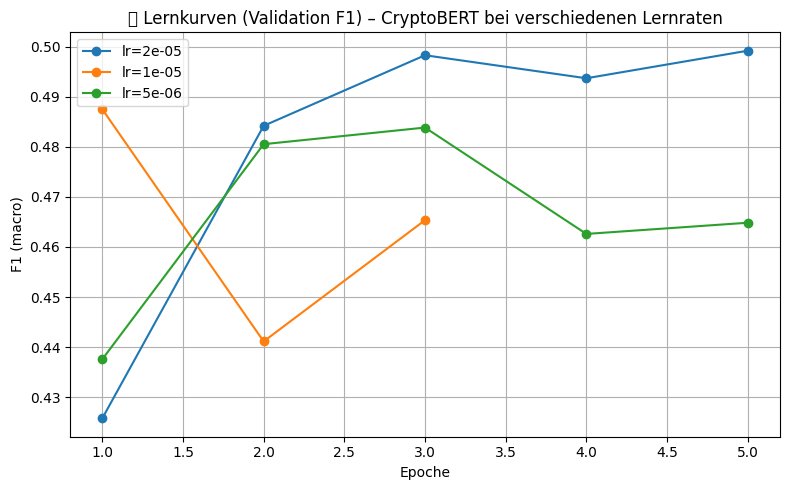

In [63]:
plt.figure(figsize=(8, 5))

for lr, data in results.items():
    df = data["f1_curve"]
    plt.plot(df["epoch"], df["eval_f1"], marker="o", label=f"lr={lr}")

plt.title("📈 Lernkurven (Validation F1) – CryptoBERT bei verschiedenen Lernraten")
plt.xlabel("Epoche")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
# Beste Lernrate bestimmen
best_lr = max(results.items(), key=lambda x: x[1]["best_f1"])[0]
best_trainer = results[best_lr]["trainer"]

print(f"\n🏆 Beste Lernrate: {best_lr} mit F1 = {results[best_lr]['best_f1']:.4f}")



🏆 Beste Lernrate: 2e-05 mit F1 = 0.4992


Evaluation im finalen Testsplit

In [65]:
test_results = best_trainer.predict(test_ds)

from sklearn.metrics import classification_report
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_results.label_ids

print("\n📊 Evaluation auf Testset:")
print(classification_report(y_true, y_pred))



📊 Evaluation auf Testset:
              precision    recall  f1-score   support

           0       0.41      0.38      0.39        37
           1       0.54      0.68      0.60        60
           2       0.20      0.06      0.09        18

    accuracy                           0.49       115
   macro avg       0.38      0.37      0.36       115
weighted avg       0.45      0.49      0.46       115



Falsche Vorhersagen

In [66]:
wrong = [(i, p, t) for i, (p, t) in enumerate(zip(y_pred, y_true)) if p != t]
wrong_df = test_df.iloc[[i for i, _, _ in wrong]].copy()
wrong_df["predicted"] = [p for _, p, _ in wrong]
wrong_df["true"] = [t for _, _, t in wrong]

wrong_df[["text", "true", "predicted"]].head(10)


,text,true,predicted
1,Favourite ALTS for 2025? There's been much tal...,0,1
2,Would you take 100% chance of getting 600k or ...,0,1
4,bahhahahha,1,0
5,India Strikes Crypto Exchange Bybit: Major Fin...,2,0
6,Traditional Investments v. Bitcoin The way I s...,0,1
7,"Bitcoin maxi posted ""Solana will be the first ...",0,1
13,Ethereum Foundation Reveals Leadership Shakeup...,2,1
14,Trip Report: Struggles of a new crypto user Hi...,2,1
16,Yeah I bought the Pepe discount\n\nI hate pepe...,0,1
17,"**Historical Bitcoin prices for today, Decembe...",1,0
